# Plot

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from cms_top_20_001_Limits import read_CMSdata, getSMLO, getKfactor

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

colors = sns.color_palette('Paired')

### Load Recast Data

In [35]:
recastDataAll = pd.read_pickle('/home/vinicius/EFT_ToyModel/Recast_CMS/pp2ttbar_cms_top_20_001.pcl')
recastDataEFTAll = pd.read_pickle('/home/vinicius/EFT_ToyModel/Recast_CMS/pp2ttbar_eft_cms_top_20_001.pcl')

### Get CMS data

In [36]:
# ### Load CMS data
xsecsObs,smNLO,covMatrix,sm_err = read_CMSdata(dataDir='/home/vinicius/EFT_ToyModel/Recast_CMS/data')
smNLO = smNLO/bin_widths
sm_err = sm_err/bin_widths
covTotal = covMatrix + np.diag( (smNLO*sm_err)**2) 
bgError = np.sqrt(covTotal.diagonal())
#bgError = np.sqrt(covMatrix.diagonal())
cms_bins = np.array([250.,400.,480.,560.,640.,720.,800.,900.,1000.,
                1150.,1300.,1500.,1700.,2000.,2300.,3500.])
bin_widths  = cms_bins[1:]-cms_bins[:-1]        

### Get SM prediction and k-factor

In [37]:
# ### Load SM prediction (LO)
smLO = getSMLO('/home/vinicius/EFT_ToyModel/Recast_CMS/sm/sm_tt_lo_cms_top_20_001.pcl')
# ### Load k-factors
kfac = 1.0#getKfactor(smNLO,smLO)
smNLO = smNLO
print(smNLO)
print(xsecsObs)

[3.27717183e-01 8.81521972e-01 5.44329014e-01 3.18260563e-01
 1.82089014e-01 1.09291268e-01 6.47404038e-02 3.65881502e-02
 1.91298404e-02 9.06418779e-03 4.25560563e-03 1.77232207e-03
 6.79761784e-04 2.36470423e-04 3.74685070e-05]
[3.442e-01 8.717e-01 5.428e-01 3.153e-01 1.809e-01 1.096e-01 6.251e-02
 3.697e-02 1.784e-02 9.005e-03 3.815e-03 1.769e-03 6.941e-04 1.905e-04
 3.147e-05]


## Light Point 1

### Select parameters

In [38]:
mPsiT = 700.0
mSDM = 690.0
yDM = 1.0

recastData = recastDataAll[(recastDataAll['mPsiT'] == mPsiT) & (recastDataAll['mSDM'] == mSDM) & (recastDataAll['yDM'] == yDM)]
recastDataEFT = recastDataEFTAll[(recastDataEFTAll['mPsiT'] == mPsiT) & (recastDataEFTAll['mSDM'] == mSDM) & (recastDataEFTAll['yDM'] == yDM)]
mPsiT,mSDM,yDM = recastData[['mPsiT','mSDM','yDM']].iloc[0]
print(mPsiT,mSDM,yDM)
print(len(recastData),len(recastDataEFT))

700.0 690.0 1.0
1 2


### Get signal

In [39]:
binCols = [c for c in recastData.columns 
               if 'bin_' in c.lower() and not 'error' in c.lower()]
bins_left = np.array([eval(c.split('_')[1]) for c in binCols])
bins_right = np.array([eval(c.split('_')[2]) for c in binCols])     
bin_centers = (bins_left+bins_right)/2.0
bin_widths = bins_right-bins_left
cms_bins = np.append(bins_left,bins_right[-1])

signal = list(zip(bins_left,recastData.iloc[0][binCols].values))
signal = np.array(sorted(signal))[:,1]

signalEFT = list(zip(bins_left,recastDataEFT.iloc[0][binCols].values))
signalEFT = np.array(sorted(signalEFT))[:,1]


### Apply k-factors and rescale by bins

In [40]:
signalNLO = signal*kfac/bin_widths
signalEFTNLO = signalEFT*kfac/bin_widths

### Plot distribution and data

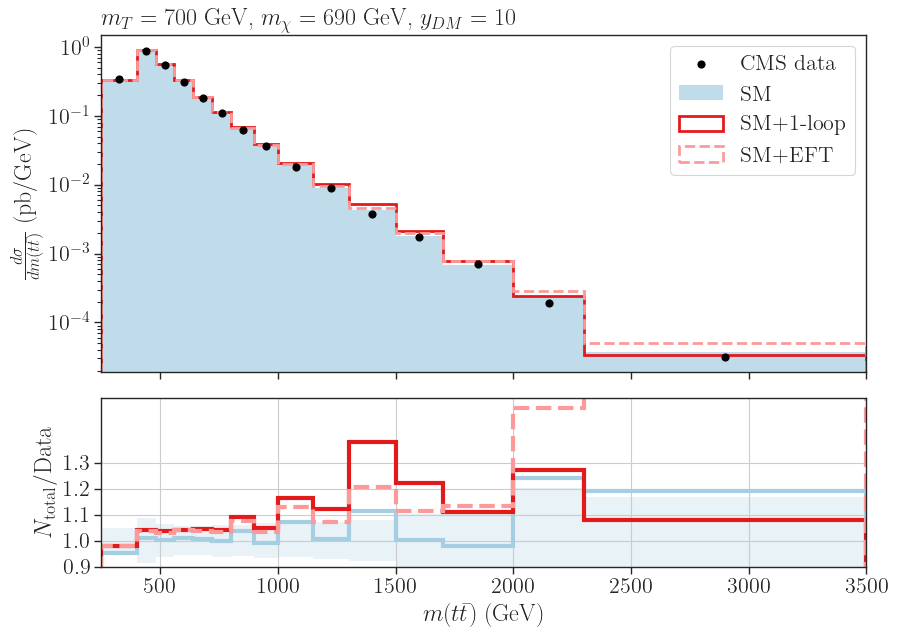

In [42]:
yDM = 10.0/recastData.iloc[0]['yDM']

_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(9,7))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

axarr[0].scatter(bin_centers,xsecsObs,label='CMS data',linewidth=2,s=15,
c='black',zorder=10)
axarr[0].hist(bin_centers,weights=smNLO,label=r'SM',histtype='step',linewidth=0,bins=cms_bins,color=colors[0],fill=True,alpha=0.7)
axarr[0].hist(bin_centers,weights=smNLO+signalNLO*yDM**2,label=r'SM+1-loop',histtype='step',linewidth=2,bins=cms_bins,color=colors[5])
axarr[0].hist(bin_centers,weights=smNLO+signalEFTNLO*yDM**2,label=r'SM+EFT',histtype='step',linewidth=2,bins=cms_bins,linestyle='dashed',color=colors[4])
axarr[0].set_yscale('log')
# axarr[0].set_ylim(1e-6,2e-2)
axarr[0].legend()
axarr[0].set_xlim(250.,3500.)
# axarr[0].grid()

axarr[1].hist(bin_centers,weights=np.divide(smNLO,xsecsObs),histtype='step',linewidth=3,bins=cms_bins,color=colors[0])
axarr[1].hist(bin_centers,weights=np.divide(smNLO+signalNLO*yDM**2,xsecsObs),histtype='step',linewidth=3,bins=cms_bins,color=colors[5])
axarr[1].hist(bin_centers,weights=np.divide(smNLO+signalEFTNLO*yDM**2,xsecsObs),histtype='step',linewidth=3,bins=cms_bins,color=colors[4],linestyle='dashed')

axarr[1].bar(x=bins_left, height=np.divide(2*bgError,xsecsObs), bottom=np.divide(xsecsObs-bgError,xsecsObs), width=bin_widths, align='edge', linewidth=0, color=colors[0], alpha=0.25, zorder=-1, label='uncertainty band')


axarr[1].set_yticks(np.arange(0.9,1.4,0.1))
axarr[1].set_ylim(0.9,1.55)
axarr[1].grid()

axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
axarr[0].set_ylabel(r'$\frac{d \sigma}{d m(t\bar{t})}$ (pb/GeV)')
axarr[1].set_ylabel(r'$N_{\rm total}/{\rm Data}$')

axarr[0].set_title(r'$m_T = %1.0f$ GeV, $m_{\chi} = %1.0f$ GeV, $y_{DM} = %1.0f$' %(mPsiT,mSDM,yDM),loc='left')
plt.savefig('CMS_mtt_mPsiT%i_mSDM%i_yDM_%i.png' %(int(mPsiT),int(mSDM),int(yDM)))
plt.show()

## Light Point 2

### Select parameters

In [11]:
mST = 1000.0
mChi = 900.0
yDM = 1.0

recastData = recastDataAll[(recastDataAll['mST'] == mST) & (recastDataAll['mChi'] == mChi) & (recastDataAll['yDM'] == yDM)]
recastDataEFT = recastDataEFTAll[(recastDataEFTAll['mST'] == mST) & (recastDataEFTAll['mChi'] == mChi) & (recastDataEFTAll['yDM'] == yDM)]
print(len(recastData),len(recastDataEFT))

KeyError: 'mST'

### Get signal

In [ ]:
binCols = [c for c in recastData.columns 
               if 'bin_' in c.lower() and not 'error' in c.lower()]
bins_left = np.array([eval(c.split('_')[1]) for c in binCols])
bins_right = np.array([eval(c.split('_')[2]) for c in binCols])     
bin_centers = (bins_left+bins_right)/2.0
bin_widths = bins_right-bins_left
cms_bins = np.append(bins_left,bins_right[-1])

signal = list(zip(bins_left,recastData.iloc[0][binCols].values))
signal = np.array(sorted(signal))[:,1]

signalEFT = list(zip(bins_left,recastDataEFT.iloc[0][binCols].values))
signalEFT = np.array(sorted(signalEFT))[:,1]


### Apply k-factors and rescale by bins

In [ ]:
signalNLO = signal*kfac/bin_widths
signalEFTNLO = signalEFT*kfac/bin_widths

### Plot distribution and data

In [ ]:
yDM = 10.0/recastData.iloc[0]['yDM']

_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(9,7))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

axarr[0].scatter(bin_centers,xsecsObs,label='CMS data',linewidth=2,s=15,
c='black',zorder=10)
axarr[0].hist(bin_centers,weights=smNLO,label=r'SM',histtype='step',linewidth=0,bins=cms_bins,color=colors[0],fill=True,alpha=0.7)
axarr[0].hist(bin_centers,weights=smNLO+signalNLO*yDM**2,label=r'SM+1-loop',histtype='step',linewidth=2,bins=cms_bins,color=colors[5])
axarr[0].hist(bin_centers,weights=smNLO+signalEFTNLO*yDM**2,label=r'SM+EFT',histtype='step',linewidth=2,bins=cms_bins,linestyle='dashed',color=colors[4])
axarr[0].set_yscale('log')
# axarr[0].set_ylim(1e-6,2e-2)
axarr[0].legend()
axarr[0].set_xlim(250.,3500.)
# axarr[0].grid()

axarr[1].hist(bin_centers,weights=np.divide(smNLO,xsecsObs),histtype='step',linewidth=3,bins=cms_bins,color=colors[0])
axarr[1].hist(bin_centers,weights=np.divide(smNLO+signalNLO*yDM**2,xsecsObs),histtype='step',linewidth=3,bins=cms_bins,color=colors[5])
axarr[1].hist(bin_centers,weights=np.divide(smNLO+signalEFTNLO*yDM**2,xsecsObs),histtype='step',linewidth=3,bins=cms_bins,color=colors[4],linestyle='dashed')

# axarr[1].bar(x=bins_left, height=np.divide(2*bgError,xsecsObs), bottom=np.divide(smNLO-bgError,xsecsObs), width=bin_widths, align='edge', linewidth=0, color=colors[0], alpha=0.25, zorder=-1, label='uncertainty band')
axarr[1].bar(x=bins_left, height=np.divide(2*bgError,xsecsObs), bottom=np.divide(xsecsObs-bgError,xsecsObs), width=bin_widths, align='edge', linewidth=0, color=colors[0], alpha=0.25, zorder=-1, label='uncertainty band')


axarr[1].set_ylim(0.8,1.4)
axarr[1].set_yticks(np.arange(0.8,1.4,0.2))
axarr[1].grid()

axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
axarr[0].set_ylabel(r'$\frac{d \sigma}{d m(t\bar{t})}$ (pb/GeV)')
axarr[1].set_ylabel(r'$N_{\rm total}/{\rm Data}$')


axarr[0].set_title(r'$m_T = %1.0f$ GeV, $m_{\chi} = %1.0f$ GeV, $y_{DM} = %1.0f$' %(mST,mChi,yDM),loc='left')
plt.savefig('CMS_mtt_mST%i_mChi%i_yDM_%i.png' %(int(mST),int(mChi),int(yDM)))
plt.show()